# SToP Search String

## Import and Merge Datasets

In [65]:
import csv

#Loading Bar
from ipywidgets import IntProgress
from IPython.display import display
import time

#String Search library
import re

#write to xls format
from openpyxl.styles import Font
from openpyxl.utils import get_column_letter
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl import Workbook
from openpyxl import load_workbook

#Array Library
import numpy

#Path
import os.path

fname = "Stop_searchstring.xlsx"

#Writing to Excel
if os.path.isfile(fname):
    wb = load_workbook(fname) #If the File already exists
else:
    wb = Workbook() #Create the File
    
import datetime
from datetime import datetime

from fuzzywuzzy import fuzz

In [50]:
community_string = "Community5"

# open the file in the write mode
f = open('{}.csv'.format(community_string), 'w', newline='')
# create the csv writer
writer = csv.writer(f, delimiter=',')
ws = wb.create_sheet('{}'.format(community_string))

ws.cell(row = 1, column = 1).value = "Searchstring"
ws.cell(row = 1, column = 2).value = "Count"

row_number = 2

med_dump = [] #Array for Medications for communities

In [51]:
#CSV Extraction

data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Medications report_{}_2017-Present_deidentified.csv'.format(community_string)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 4 - Product Name
# 13 - Start Date
        
Med_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Product_Name = data[a][4]
    Start_Date = data[a][13]
    
    Med_Array.append([ID, Product_Name, Start_Date])
    
data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Progressnote report_{}_2017-Present_deidentified.csv'.format(community_string)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 1 - Date
# 2 - User Name Designation
# 3 - Presenting Complaint
# 4 - Primary Presenting Complaint
# 5 - Other Complaints
# 6 - Diagnosis
# 10 - Hour of Date Of Birth
        
Prog_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Date = data[a][1]
    UserName = data[a][2] # Who is writing the progressnote
    Presenting_complaint = data[a][3]
    Primary_presenting_complaint = data[a][4]
    Other_complaints = data[a][5]
    Diagnosis = data[a][6]
    DOB = data[a][10]
    
    Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])

Med_Array and Prog_Array contain some duplicates. Remove the duplicates for much less data combined data

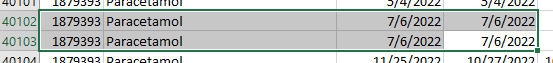

In [52]:
#Removing Duplicates
new_Med_Array = []

seen = set()
for item in Med_Array:
    t = tuple(item)
    if t not in seen:
        new_Med_Array.append(item)
        seen.add(t)
        
new_Prog_Array = []

seen = set()
for item in Prog_Array:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array.append(item)
        seen.add(t)

In [53]:
#Finding all the unique Identifiers from Med_Array (Combination of ID + Date)
UID = []
for a in range (0, len(new_Med_Array)):
    ID = new_Med_Array[a][0]
    Start_Date = new_Med_Array[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID:
        UID.append(temp)
        
for a in range (0, len(new_Prog_Array)):
    ID = new_Prog_Array[a][0]
    Date = new_Prog_Array[a][1]
    
    temp = [ID, Date]
    if temp not in UID:
        UID.append(temp)

In [54]:
# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID[a][0]
    Date = UID[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array)):
        if ID == new_Med_Array[b][0] and Date == new_Med_Array[b][2]:
            temp.append(new_Med_Array[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array)):
        if ID == new_Prog_Array[b][0] and Date == new_Prog_Array[b][1]:
            temp.append(new_Prog_Array[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)

IntProgress(value=1, max=175, min=1)

In [55]:
#Save the merged dataset as a pickle file
import pickle as pkl

with open('{}.pkl'.format(community_string),'wb') as f:
    pkl.dump(Data_Array, f)

## Fuzzy Search Analysis

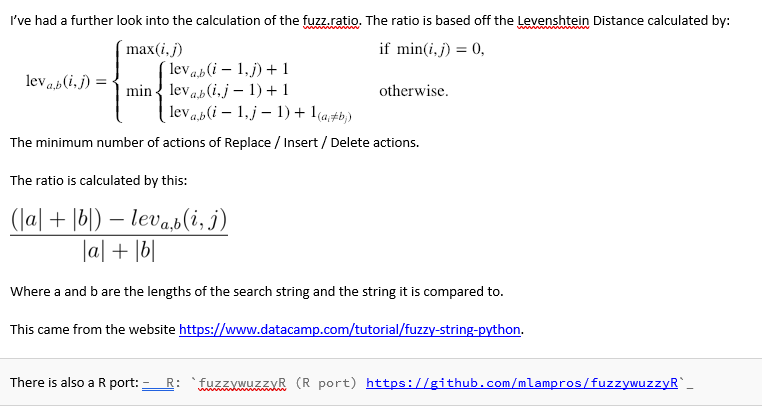

In [29]:
#All the search terms
search = ["dressing", "laceration", "cut", "wound", "bite", "boil", "abscess", "skin", "rash", "sores", "impetigo", "pyoderma", "school sores", "skin sores", "purulent", "crusted", "fungal", "tinea", "ring worm", "scaly skin", "lice", "nit", "head lice", "scalp infestation", "dermatitis", "eczema", "atopic dermatitis", "infected eczema", "wart", "molluscum", "scabies", "scabetic", "secondarily infected scabies", "impetiginous scabies"]
pickle_files = ["Community1", "Community2", "Community3", "Community4", "Community5"]

#Create Fuzzy Dictionary
fuzzy_dictionary = {}
for searchstring in search:
    fuzzy_dictionary[searchstring] = []

#Iterate through the community Files
for pickle in pickle_files:
    print(pickle)
    with open('{}.pkl'.format(pickle),'rb') as f:
        Data_Array = pkl.load(f)
    fuzz_score = []
    
    #Iterate through the different search strings
    for searchstring in search: 
        temp = []
        for a in range (0, len(Data_Array)):
            if len(Data_Array[a]) != 0:
                temp_id = Data_Array[a][1][0][0]
                temp_DOB = Data_Array[a][1][0][6]
                temp_date = Data_Array[a][1][0][1]

                temp_string = ""
                for b in range (0, len(Data_Array[a][1])):
                    temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "

                    if Data_Array[a][1][b][0] != temp_id:
                        print("ID ERROR")
                    if Data_Array[a][1][b][6] != temp_DOB:
                        print("DOB ERROR")
                    if Data_Array[a][1][b][1] != temp_date:
                        print("Date ERROR")

                #Convert string to lowercase
                temp_string = temp_string.lower()

                #Split the list into separate words
                temp_string_split = temp_string.replace("/"," ").split(" ")

                #Check to see if ANY of the words match the search string
                for string in temp_string_split:
                    fuzz_ratio = fuzz.ratio(searchstring, string)
                    fuzz_score.append([fuzz_ratio, searchstring, string])

    for a in range (0, len(fuzz_score)):
        if fuzz_score[a][0] != 100:
            searchstring = fuzz_score[a][1]
            if fuzz_score[a] not in fuzzy_dictionary[searchstring]:
                fuzzy_dictionary[searchstring].append(fuzz_score[a])

for key in fuzzy_dictionary:
    print(key, len(fuzzy_dictionary[key]))

Community1
Community2
Community3
Community4
Community5
dressing 9389
laceration 9389
cut 9389
wound 9389
bite 9389
boil 9389
abscess 9389
skin 9389
rash 9389
sores 9389
impetigo 9389
pyoderma 9389
school sores 9390
skin sores 9390
purulent 9389
crusted 9389
fungal 9389
tinea 9389
ring worm 9390
scaly skin 9390
lice 9389
nit 9389
head lice 9390
scalp infestation 9390
dermatitis 9389
eczema 9389
atopic dermatitis 9390
infected eczema 9390
wart 9389
molluscum 9389
scabies 9389
scabetic 9390
secondarily infected scabies 9390
impetiginous scabies 9390


In [31]:
Threshold_array = []
for threshold in range (0, 100):
    count = 0
    for key in fuzzy_dictionary:
        for a in range (0, len(fuzzy_dictionary[key])):
            if fuzzy_dictionary[key][a][0] > threshold:
                count = count + 1
                
    print(threshold, count)
    Threshold_array.append([threshold, count])

0 271729
1 271729
2 271729
3 271729
4 271729
5 271729
6 271401
7 271230
8 270647
9 269334
10 266495
11 261322
12 250848
13 242593
14 232219
15 219408
16 218174
17 202604
18 188567
19 184605
20 171601
21 165366
22 150252
23 148368
24 137634
25 120772
26 117777
27 103931
28 102843
29 85635
30 80750
31 70181
32 64013
33 49656
34 48994
35 42687
36 35981
37 35385
38 29047
39 28815
40 20019
41 19764
42 17911
43 14669
44 11374
45 11048
46 9099
47 7853
48 7347
49 7342
50 4121
51 4121
52 3982
53 3102
54 3066
55 2351
56 2096
57 1496
58 1471
59 1288
60 945
61 918
62 671
63 618
64 588
65 584
66 584
67 274
68 274
69 273
70 251
71 209
72 208
73 180
74 171
75 124
76 122
77 113
78 104
79 103
80 79
81 79
82 76
83 76
84 73
85 73
86 63
87 63
88 59
89 28
90 27
91 19
92 16
93 10
94 2
95 0
96 0
97 0
98 0
99 0


In [34]:
fuzzy_threshold = []
for key in fuzzy_dictionary:
    for a in range (0, len(fuzzy_dictionary[key])):
        if fuzzy_dictionary[key][a][0] > 65:
            #print(fuzzy_dictionary[key][a])
            fuzzy_threshold.append(fuzzy_dictionary[key][a])
            
fuzzy_threshold = sorted(fuzzy_threshold, key = lambda x: (x[1], x[0]))

In [43]:
for a in range (0, len(fuzzy_threshold)):
    fuzzy_threshold[a].append(0)

In [47]:
fuzzy_threshold

[[67, 'abscess', 'aches', 0],
 [67, 'abscess', 'accessed', 0],
 [67, 'abscess', 'abuse', 0],
 [67, 'abscess', 'sickness', 0],
 [67, 'abscess', 'business', 0],
 [67, 'abscess', 'reassess', 0],
 [71, 'abscess', 'ascites', 0],
 [71, 'abscess', 'absence', 0],
 [77, 'abscess', 'assess', 0],
 [77, 'abscess', 'access', 0],
 [80, 'abscess', 'absences', 0],
 [80, 'abscess', '??abcess', 0],
 [86, 'abscess', 'abcess.', 0],
 [86, 'abscess', 'abcsess', 0],
 [88, 'abscess', 'abscesses', 0],
 [88, 'abscess', 'abscessed', 0],
 [92, 'abscess', 'abcess', 0],
 [92, 'abscess', 'absess', 0],
 [93, 'abscess', 'abscess,', 0],
 [93, 'abscess', 'abscess.', 0],
 [93, 'abscess', '?abscess', 0],
 [67, 'atopic dermatitis', 'stomatitis', 0],
 [74, 'atopic dermatitis', 'dermatitis', 0],
 [67, 'bite', 'be', 0],
 [67, 'bite', 'titer', 0],
 [67, 'bite', 'sites', 0],
 [67, 'bite', 'birth', 0],
 [67, 'bite', 'binge', 0],
 [67, 'bite', 'blisters', 0],
 [67, 'bite', 'brief', 0],
 [67, 'bite', '?redbite', 0],
 [67, 'bite', 

In [58]:
true_positive = []

temp = [["dresisng.","dressing"],["dresisng","dressing"],["redressing","dressing"],["dressings.","dressing"],["dressings\\","dressing"],["dressings?","dressing"],["dressing.","dressing"],["dressings","dressing"],["dressing,","dressing"],["dressing-","dressing"]]
for a in range (0, len(temp)):
    true_positive.append(temp[a])
    
temp = [["lacerated","laceration"],["lacerations,","laceration"],["laceration,","laceration"],["lacerations","laceration"],["cut's","cut"],["cutts","cut"],["cuts,","cut"],["cuts","cut"]]
for a in range (0, len(temp)):
    true_positive.append(temp[a])
    
temp = [["wounds","wound"],["wound,","wound"],["wound.","wound"],[",wound","wound"],["?redbite","bite"],["dog-bite","bite"],["dogbite","bite"],["flybite","bite"],["bitten","bite"],["bites?","bite"],["?bite","bite"],["bites?","bite"],["bite.","bite"],["bite?","bite"],["boils,","boil"],["boils","boil"],["?boil","boil"],["boil,","boil"],["boil?","boil"],["boil.","boil"],["boil)","boil"],["boils","boil"],["??abcess","abscess"],["abcess.","abscess"],["abcsess","abscess"],["abscesses","abscess"],["abscessed","abscess"],["abcess","abscess"],["absess","abscess"],["abscess,","abscess"],["abscess.","abscess"],["?abscess","abscess"],["skin,","skin"],["sjkin","skin"],["skin.","skin"],["skiin","skin"],["rash.","rash"],["rash,","rash"]]
for a in range (0, len(temp)):
    true_positive.append(temp[a])
    
temp = [["impetigo-type","impetigo"],["impetago","impetigo"],["(impetigo)","impetigo"],["impetig","impetigo"],["impetigo,","impetigo"],["impertigo","impetigo"],["sores.","sores"],["sores,","sores"],["fungus","fungal"],["ringwomb","ring worm"],["(ringworm)","ring worm"],["ringworm,","ring worm"],["ringworm","ring worm"],["headlice,","head lice"],["headlice","head lice"],["nits","nit"],["lice,","lice"],["lice)","lice"],["eczma","eczema"],["warts,","wart"],["warts","wart"],["molloscum","molluscum"],["scabie","scabies"],["scabies,","scabies"],["?scabies","scabies"],["scabies","scabetic"],["scabie","scabetic"]]
for a in range (0, len(temp)):
    true_positive.append(temp[a])

for a in range (0, len(true_positive)):
    search_positive = true_positive[a][0]
    search_string = true_positive[a][1]
    
    flag = 0
    for b in range (0, len(fuzzy_threshold)):
        if fuzzy_threshold[b][1] == search_string and fuzzy_threshold[b][2] == search_positive:
            fuzzy_threshold[b][-1] = 1
            flag = 1
            
    if flag == 0:
        print(a, true_positive[a])

In [62]:
fuzzy_threshold[0]

[67, 'abscess', 'aches', 0]

In [64]:
false_positive_array = []
true_positive_array = []
x_axis_array = []

for a in range (100, 65, -1):
    false_count = 0
    true_count = 0
    
    for b in range (0, len(fuzzy_threshold)):
        if fuzzy_threshold[b][0] >= a:
            if fuzzy_threshold[b][-1] == 1:
                true_count = true_count + 1
            if fuzzy_threshold[b][-1] == 0:
                false_count = false_count + 1
                
    false_positive_array.append(false_count)
    true_positive_array.append(true_count)
    x_axis_array.append(a)

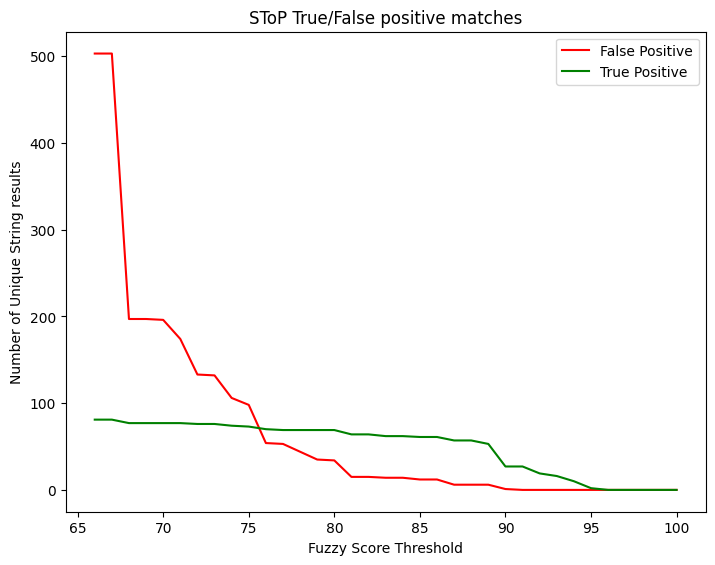

In [73]:
import matplotlib.pyplot as plt
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(x_axis_array, false_positive_array, label = "False Positive", color = "red")
ax.plot(x_axis_array, true_positive_array, label = "True Positive", color = "green")

plt.legend()
plt.title("SToP True/False positive matches")
plt.ylabel("Number of Unique String results")
plt.xlabel("Fuzzy Score Threshold")

plt.show()

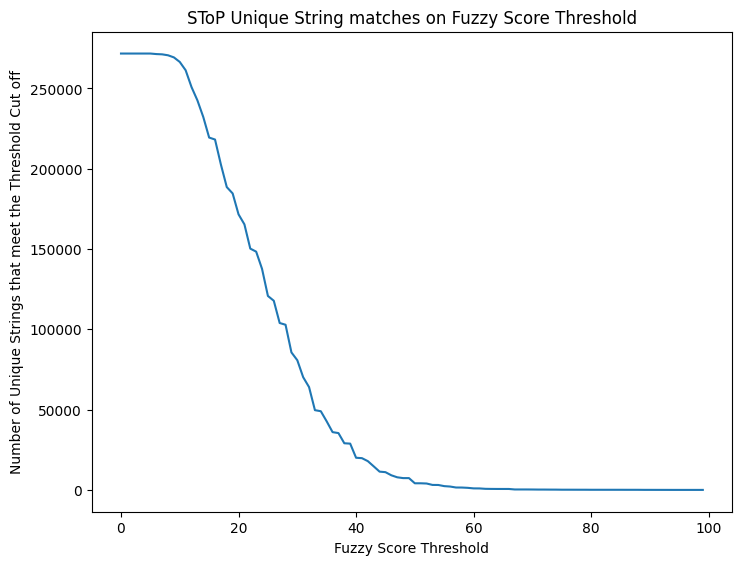

In [40]:
import matplotlib.pyplot as plt

cutoff_array = []
threshold_count_array = []
for a in range (0, len(Threshold_array)):
    cutoff_array.append(Threshold_array[a][0])
    threshold_count_array.append(Threshold_array[a][1])
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(cutoff_array, threshold_count_array)

#Show every 6 months
# temp = ax.xaxis.get_ticklabels()
# temp = list(set(temp) - set(temp[::6]))
# for label in temp:
#     label.set_visible(False)

# plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
# plt.grid(True, linestyle="dashed")
# plt.legend(bbox_to_anchor=(1.3,1), loc="upper right")

plt.title("SToP Unique String matches on Fuzzy Score Threshold")
plt.ylabel("Number of Unique Strings that meet the Threshold Cut off")
plt.xlabel("Fuzzy Score Threshold")

plt.show()

In [71]:
temp = []
for a in range (0, len(fuzzy_threshold)):
    if fuzzy_threshold[a][1] not in temp:
        print(fuzzy_threshold[a][1])
        temp.append(fuzzy_threshold[a][1])

abscess
atopic dermatitis
bite
boil
crusted
cut
dermatitis
dressing
eczema
fungal
head lice
impetigo
infected eczema
laceration
lice
molluscum
nit
purulent
pyoderma
rash
ring worm
scabetic
scabies
scalp infestation
school sores
skin
skin sores
sores
tinea
wart
wound


In [111]:
# for a in range (0, len(fuzzy_threshold)):
#     if fuzzy_threshold[a][1] == "scabetic":
#         print (fuzzy_threshold[a][0])

## Load Merged Data

In [119]:
#Load the pickle file
import pickle as pkl

pickle_files = ["Community1", "Community2", "Community3", "Community4", "Community5"]
Data_Array_List = []

for community_string in pickle_files:
    with open('{}.pkl'.format(community_string),'rb') as f:
        Data_Array = pkl.load(f)
        
    Data_Array_List.append(Data_Array)

In [31]:
#Counting the completeness of the columns in progress reports.

count_total = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0

for a in range (0, len(Data_Array_List)):
    for b in range (0, len(Data_Array_List[a])):
        if len(Data_Array_List[a][b][1]) != 0:
            for c in range (0, len(Data_Array_List[a][b][1])):
                count_total = count_total + 1
                if Data_Array_List[a][b][1][c][2] != '':
                    count_1 = count_1 + 1
                if Data_Array_List[a][b][1][c][3] != '':
                    count_2 = count_2 + 2
                if Data_Array_List[a][b][1][c][4] != '':
                    count_3 = count_3 + 3
                if Data_Array_List[a][b][1][c][5] != '':
                    count_4 = count_4 + 4

count_list = [count_1, count_2, count_3, count_4]

In [32]:
for a in range (0, len(count_list)):
    print(count_list[a], count_list[a]/count_total)

55881 0.2144641753754399
161364 0.6192945222040136
30369 0.11655236201887466
127088 0.48774759077528873


In [204]:
# Search for the search terms

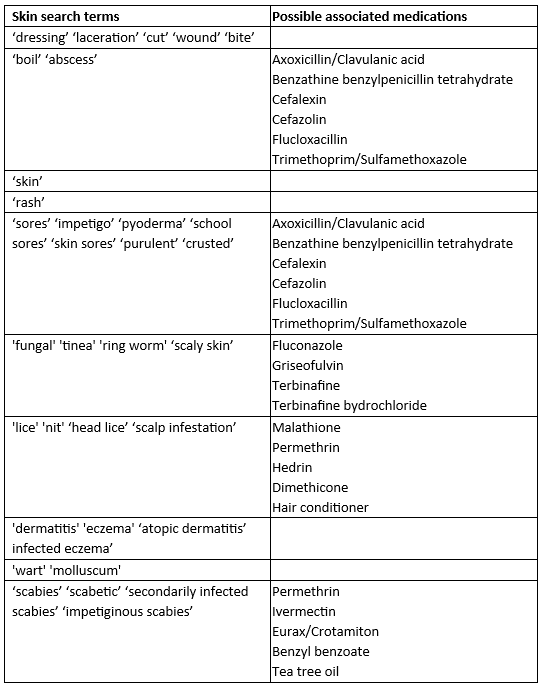

## String Search (Progress Reports)

In [5]:
import datetime
from datetime import datetime

from fuzzywuzzy import fuzz

In [13]:
#Create the search box and exclusion criteria
search_array = []
exclusion_array = []
medication_array = []

#Search1
search_array.append(["dressing", "laceration", "cut", "wound", "bite"])
exclusion_array.append(["requesting","passing","driving","aggression","missing","presenting","testing","reading","dispensing","increasing","depressive","remission","ring","drawing","nursing","restarting","dryness","persisting","address","discussing","predisposing","review,dressing","remission","during","resolving","dosing","agression","deming","depression-","processing","depression,","residing","refusing","crossing","drssg","depression","decreasing","processing","undressing","vaccination","eruption","perforation","ratio","dehydration","exertion","observation","respiration","abrasion","reaction","dislocation","ideation","ligation","contraction","application","abortion","micturation","interaction","preparation","excoriation","perofration","termination","aggregation","deprivation","retardation","ablation","duration","rotation","eventration","circulation","fraction","erection","explanation","ejaculation","evacuation","aspiration","saturation","extraction","certification","alienation","ulcerative","retraction","concentration","dilatation","consideration","starvation","clarification","separation","relocation","cessation,","activation","actions","lersion","cancellation","conversation","claudication","cessation","elevation","operation","action","ration","altercation","exacerbations","incarceration","creation","location","exacerbation:","alteration","exacerbation","lactation","exaceration","ulceration","out","uti","acuity","(acute","but","count,","ctg","cst","oct","put","crutch","utd","cat","occult","nut","icu","caught","act","acute","court","count,","ct","wind","wont","worn","wong","grounds","around","sounds","found","sound","would","round","bound","be","titer","sites","birth","binge","blisters","brief","white","bi","bilat","habit","items","bt","blister,","blister","birthed","brittle","site","item","btse","bike","mite","bile","bit"])
medication_array.append([])

#Search2
search_array.append(["boil", "abscess"])
exclusion_array.append(["bowel","billi","bi","bilat","bills","boris","bill","build","bl","bile","bill","bili","oil","aches","accessed","abuse","sickness","business","reassess","ascites","absence","assess","access","absences"])
medication_array.append([["axoxicillian", "clavulanic"], ["benzathine", "benzylpenicillin", "tetrahydrate"], ["cefalexin"], ["cefazolin"], ["flucloxacillin"], ["trimethoprim", "sulfamethoxazole"]])

#Search3
search_array.append(["skin", "rash"])
exclusion_array.append(["in","spine","signs","sinus","since","sting","smoking.","foreskin","spina","using","stocking","swing","shins","si","shin.","smoking","seeking","shaking","skintag","sign","king","shin","asking","crush","flash","brams","as","sasha","sh","ah","areas","fresh","grams","trach","lash","wash","nash","rats","rays","rashes","ash","crash"])
medication_array.append([])
                       
#Search4
search_array.append(["sores", "impetigo", "pyoderma", "school sores", "skin sores", "purulent", "crusted"])
exclusion_array.append(["rest","sutures","sole","stutres","courses","resp","does","workers","some","more","uses","ovaries","worries","toes","lore","core","sure","stress,","source,","orders.","storage","shoe","shortness","disorders","resources","sores+low","stress","stones","source","scopes","series","soreness","sore,","(sore","sorts","score","sore.","soles","sore","vertigo","imprest","completion","meeting","limping","intertrigo","lentigo","imprinting","impaction","provera","derm","lymphodema","oedema.","oedema","myxoedema","odema","school","school-based","sores","scissors","sinuses.","kintore.","kintore","sinuses","current","present","prue","parents","pustule","uregent","urgent","parent","uregnt","acute","cause","confused","crush","circumcised","unsteady","created.","unsuited","ruptured","refused","erupted","requesteed","bruised","custody","cluster","created","requested","used","requested","reqeusted","caused"])
medication_array.append([["axoxicillian", "clavulanic"], ["benzathine", "benzylpenicillin", "tetrahydrate"], ["cefalexin"], ["cefazolin"], ["flucloxacillin"], ["trimethoprim", "sulfamethoxazole"]])

#Search5
search_array.append(["fungal", "tinea", "ring worm"])
exclusion_array.append(["unable","subungual","final","antifungal","funeral","team","uterine","tear","near","stained","time","line","thin","routine","fine","twin","tera","retinal","instead","nine","?tia","gina","(tia","itinerary","tia","?rigor","ringer","rigors","inform","rigor","pinworm"])
medication_array.append([["fluconazole"], ["griseofulvin"], ["terbinafine"], ["terbinafine", "bydrochloride"]])

#Search6
search_array.append(["lice", "nit", "head lice", "scalp infestation"])
exclusion_array.append(["ulcer","liver","clavicle","since","colic","clinc","iliac","headlice","folic","lives","voice","piece","twice","follicle","lance","click","neice","licence","license","police.","police)","policed","like","line","life","live","police","lichen","ice","alice","not","ent","fit","nil","hit","ant","insitu","donita","night,","sit","itp","vit","bit","nut","itc","united","night.","kit","nipt-r","invite","night","unfit","units","nt","unit","healed","headache","advice","headache","headaches","healch","headcahes","headache","alice","investigation","alienation","adminstration","palpitations","infestation"])
medication_array.append([["malathione"], ["permethrin"], ["hedrin"], ["dimethicone"], ["hair", "conditioner"]])

#Search7
search_array.append(["dermatitis", "eczema", "atopic dermatitis", "infected eczema"])
exclusion_array.append(["diverticulitis","prostatitis","mastoiditis","dermatomycosis","adenitis","peritonitis","diabitis","extremities","hepaitis","neuritis","stomatitis","dermatologist","dermatophytosis","hepatitis","mastitis","keratitis","oedema","edema","infected.","infeccted","infected"])
medication_array.append([])

#Search8
search_array.append(["wart", "molluscum"])
exclusion_array.append(["wrist","at","heart","wears","wt","chart","party","wa","wants","watts",'"what',"wrote","sweat","alert","start","aware","rt","water","parts","wait","warm","ward","want","part"])
medication_array.append([])

#Search9
search_array.append(["scabies", "scabetic", "secondarily infected scabies", "impetiginous scabies"])
exclusion_array.append(["bites","sites","aides","cannabis","scars","calories","canis","swabs","scale","ascites","species","scab","caries","scales","scratch","scarlet","caustic","ciatica","scab","?septic","septic","ischaemic","diabetic-","cachectic","ishcaemic","sciatica","diabetic"])
medication_array.append([["permethrin"], ["ivermectin"], ["eurax", "crotamiton"], ["benzyl", "benzoate"], ["tea", "tree", "oil"]])

In [15]:
#Iterate through the communities
for community_number in range(0, len(Data_Array_List)):
    
    Data_Array = Data_Array_List[community_number]
    community_string = pickle_files[community_number]
    print(community_string)
    
    # Open the file in the write mode
    f = open('{}.csv'.format(community_string), 'w', newline='')
    # create the csv writer
    writer = csv.writer(f, delimiter=',')
    
    # Open the file in the write mode
    f_med = open('{}_med.csv'.format(community_string), 'w', newline='')
    # create the csv writer
    writer_med = csv.writer(f_med, delimiter=',')    
    
    ws = wb.create_sheet('{}'.format(community_string))
    ws.cell(row = 1, column = 1).value = "Searchstring"
    ws.cell(row = 1, column = 2).value = "Count"
    row_number = 2

    #Iterate through the search categories
    for search_catagory in range (0, len(search_array)):
        search = search_array[search_catagory]
        exclusion = exclusion_array[search_catagory]
        med = medication_array[search_catagory]
        
        results_array = []
        med_dump = []
        for searchstring in search: 
            #print(searchstring)
            temp = []
            for a in range (0, len(Data_Array)):
                if len(Data_Array[a]) != 0:
                    temp_id = Data_Array[a][1][0][0]
                    temp_DOB = Data_Array[a][1][0][6]
                    temp_date = Data_Array[a][1][0][1]
                    temp_User = Data_Array[a][1][0][-1]

                    temp_string = ""
                    for b in range (0, len(Data_Array[a][1])):
                        temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "

                        if Data_Array[a][1][b][0] != temp_id:
                            print("ID ERROR")
                        if Data_Array[a][1][b][6] != temp_DOB:
                            print("DOB ERROR")
                        if Data_Array[a][1][b][1] != temp_date:
                            print("Date ERROR")

                    #Convert string to lowercase
                    temp_string = temp_string.lower()

                    #Convert to datetime.date() so it can be used to compare for consecutive windows
                    temp_date = Data_Array[a][1][b][1]

                    if temp_date != 'Day of Progress Note Date':
                        temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

                    #Split the list into separate words
                    temp_string_split = temp_string.replace("/", " ").split(" ")

                    #Check to see if ANY of the words match the search string
                    flag = False
                    for string in temp_string_split:
                        fuzz_ratio = fuzz.ratio(searchstring, string)
                        if fuzz_ratio > 65 and string not in exclusion:
                            # if fuzz_ratio != 100:
                            #     print(a, searchstring, string, fuzz_ratio, temp_string_split)
                            flag = True

                    if flag == True:
                        temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB, temp_User]) 
            results_array.append(temp)

        #Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
        for a in range (0, len(results_array)):
            results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))

        #Iterate through the results_array to check to see if anyone is within the same time window
        for a in range (0, len(results_array)):
            delete_array = []
            for b in range (1, len(results_array[a])):
                #If the ID is the same
                if results_array[a][b][1] == results_array[a][b-1][1]:
                    #Check date
                    date1 = results_array[a][b-1][2]
                    date2 = results_array[a][b][2]

                    #If it is less than 4 days
                    if (date2 - date1).days < 4:
                        #print(b, date1, date2)
                        delete_array.append(b)

            #print(delete_array)
            #Reverse Order of the delete array
            delete_array.sort(reverse=True)

            #Delete those rows in the array
            for b in range (0, len(delete_array)):
                del results_array[a][delete_array[b]]
                
        #Find the associated medications
        #Create a Medication Results array with the same dimensions as the search terms
        med_array = []
        if len(med) > 0:
            for a in range (0, len(results_array)):
                med_results = [0 for a in range (0, len(med))]
                for b in range (0, len(results_array[a])):
                    #Find the Data row that the result comes from
                    data_row = results_array[a][b][0]
                    temp_datarow = Data_Array[data_row][0] #The medication reports
                    temp_date = results_array[a][b][2] #Date
                    temp_classification = search[a]

                    #Check to see if there are any medication reports linked to this progress note
                    if len(temp_datarow) > 0:
                        for c in range (0, len(temp_datarow)):
                            med_string = temp_datarow[c][1].lower()

                            #Iterate through the search terms
                            for d in range (0, len(med)):

                                flag = False #Flag to determine if subsets of the medical terms is present

                                for e in range (0, len(med[d])):
                                    medSearchString = med[d][e]
                                    if re.search(medSearchString, med_string):
                                        #print(medSearchString, "--------", med_string)
                                        flag = True

                                if flag:
                                    med_results[d] = med_results[d] + 1
                                    excel_write = [temp_datarow[c], temp_date, temp_classification, med[d]]
                                    writer_med.writerow(excel_write)
                med_array.append(med_results)
        
        #Write to xlsx sheet
        for a in range (0, len(results_array)):
            ws.cell(row = row_number, column = 1).value = search[a]
            ws.cell(row = row_number, column = 2).value = len(results_array[a])

            #Write the medications associated with each search term
            if len(med) > 0:
                for b in range (0, len(med)):
                    temp_string = ""
                    for i in med[b]:
                        temp_string += i
                    ws.cell(row = row_number, column = 4 + b).value = temp_string
                    ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            row_number = row_number + 2
            
        #Write the medications to csv for plotting

        #Write the results to csv for plotting
        for a in range (0, len(results_array)):
            for b in range (0, len(results_array[a])):
                excel_write = [search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5], results_array[a][b][6]]
                #print(excel_write)
                writer.writerow(excel_write)

        wb.save("Stop_searchstring.xlsx")    

Community1
Community2
Community3
Community4
Community5


## String Search (Medication)

In [6]:
#Plot the usages for medications for these two searchstrings

# -	Benzathinebenzylpenicillintetrahydrate vs. trimethoprimsulfamethoxazole use for impetigo, over time
# -	Permethrin vs. ivermectin use for scabies, over time

#Iterate through the communities
for community_number in range(0, len(Data_Array_List)):
    
    Data_Array = Data_Array_List[community_number]
    community_string = pickle_files[community_number]
    print(community_string)
    
    # Open the file in the write mode
    f = open('{}.csv'.format(community_string), 'w', newline='')
    # create the csv writer
    writer = csv.writer(f, delimiter=',')
    ws = wb.create_sheet('{}'.format(community_string))

    ws.cell(row = 1, column = 1).value = "Searchstring"
    ws.cell(row = 1, column = 2).value = "Count"
    row_number = 2

    #Iterate through the search categories
    for search_catagory in range (0, len(search_array)):
        search = search_array[search_catagory]
        exclusion = exclusion_array[search_catagory]
        med = medication_array[search_catagory]
        
        results_array = []
        for searchstring in search: 
            #print(searchstring)
            temp = []
            for a in range (0, len(Data_Array)):
                if len(Data_Array[a]) != 0:
                    temp_id = Data_Array[a][1][0][0]
                    temp_DOB = Data_Array[a][1][0][6]
                    temp_date = Data_Array[a][1][0][1]
                    temp_User = Data_Array[a][1][0][-1]

                    temp_string = ""
                    for b in range (0, len(Data_Array[a][1])):
                        temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "

                        if Data_Array[a][1][b][0] != temp_id:
                            print("ID ERROR")
                        if Data_Array[a][1][b][6] != temp_DOB:
                            print("DOB ERROR")
                        if Data_Array[a][1][b][1] != temp_date:
                            print("Date ERROR")

                    #Convert string to lowercase
                    temp_string = temp_string.lower()

                    #Convert to datetime.date() so it can be used to compare for consecutive windows
                    temp_date = Data_Array[a][1][b][1]

                    if temp_date != 'Day of Progress Note Date':
                        temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

                    #Split the list into separate words
                    temp_string_split = temp_string.replace("/", " ").split(" ")

                    #Check to see if ANY of the words match the search string
                    flag = False
                    for string in temp_string_split:
                        fuzz_ratio = fuzz.ratio(searchstring, string)
                        if fuzz_ratio > 65 and string not in exclusion:
                            # if fuzz_ratio != 100:
                            #     print(a, searchstring, string, fuzz_ratio, temp_string_split)
                            flag = True

                    if flag == True:
                        temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB, temp_User]) 
            results_array.append(temp)

        #Sort by patient ID so that we can remove consecutive clinic visits (within 3 days)
        for a in range (0, len(results_array)):
            results_array[a] = sorted(results_array[a], key=lambda l: (int(l[1]), l[2]))

        #Iterate through the results_array to check to see if anyone is within the same time window
        for a in range (0, len(results_array)):
            delete_array = []
            for b in range (1, len(results_array[a])):
                #If the ID is the same
                if results_array[a][b][1] == results_array[a][b-1][1]:
                    #Check date
                    date1 = results_array[a][b-1][2]
                    date2 = results_array[a][b][2]

                    #If it is less than 4 days
                    if (date2 - date1).days < 4:
                        #print(b, date1, date2)
                        delete_array.append(b)

            #print(delete_array)
            #Reverse Order of the delete array
            delete_array.sort(reverse=True)

            #Delete those rows in the array
            for b in range (0, len(delete_array)):
                del results_array[a][delete_array[b]]
                
        #Find the associated medications
        #Create a Medication Results array with the same dimensions as the search terms
        med_array = []
        if len(med) > 0:
            for a in range (0, len(results_array)):
                med_results = [0 for a in range (0, len(med))]
                for b in range (0, len(results_array[a])):
                    #Find the Data row that the result comes from
                    data_row = results_array[a][b][0]
                    temp_datarow = Data_Array[data_row][0] #The medication reports
                    temp_date = results_array[a][b][2] #Date
                    temp_classification = search[a]

                    #Check to see if there are any medication reports linked to this progress note
                    if len(temp_datarow) > 0:
                        for c in range (0, len(temp_datarow)):
                            med_string = temp_datarow[c][1].lower()

                            #Iterate through the search terms
                            for d in range (0, len(med)):

                                flag = False #Flag to determine if subsets of the medical terms is present

                                for e in range (0, len(med[d])):
                                    medSearchString = med[d][e]
                                    if re.search(medSearchString, med_string):
                                        #print(medSearchString, "--------", med_string)
                                        flag = True

                                if flag:
                                    med_results[d] = med_results[d] + 1
                                    med_dump.append([temp_datarow[c], temp_date, temp_classification, med[d]])
                med_array.append(med_results)
        
        #Write to xlsx sheet
        for a in range (0, len(results_array)):
            ws.cell(row = row_number, column = 1).value = search[a]
            ws.cell(row = row_number, column = 2).value = len(results_array[a])

            #Write the medications associated with each search term
            if len(med) > 0:
                for b in range (0, len(med)):
                    temp_string = ""
                    for i in med[b]:
                        temp_string += i
                    ws.cell(row = row_number, column = 4 + b).value = temp_string
                    ws.cell(row = row_number + 1, column = 4 + b).value = med_array[a][b]
            row_number = row_number + 2

Community1
Community2
Community3
Community4
Community5


## ALL SEARCH DATA DUMP

In [18]:
Data_Array = Data_Array_List[0]

In [20]:
Data_Array[1][1][1][1]

'11/12/2017'

In [21]:
Data_Array[1][1][0][1]

'11/12/2017'

In [22]:
temp_date

datetime.date(2019, 5, 18)

In [26]:
#Iterate through the communities
for community_number in range(0, len(Data_Array_List)):
    
    Data_Array = Data_Array_List[community_number]
    community_string = pickle_files[community_number]
    print(community_string)
    
    #Open Excel
    f = open('{}_noWindow.csv'.format(community_string), 'w', newline='')
    writer = csv.writer(f, delimiter=',')
    Headings = ["Unique ID (patient + presentation date)","Search String", "Subject ID", "Date", "Progress Note", "Date of birth", "User Name Designation", "Fuzzy Score"]
    writer.writerow(Headings)
    
    #Iterate through the search categories
    for search_catagory in range (0, len(search_array)):
        search = search_array[search_catagory]
        exclusion = exclusion_array[search_catagory]
        med = medication_array[search_catagory]
        
        results_array = []
        for searchstring in search: 
            #print(searchstring)
            temp = []
            for a in range (0, len(Data_Array)):
                if len(Data_Array[a]) != 0:
                    temp_id = Data_Array[a][1][0][0]
                    temp_DOB = Data_Array[a][1][0][6]
                    temp_date_first = Data_Array[a][1][0][1]
                    temp_User = Data_Array[a][1][0][-1]

                    for b in range (0, len(Data_Array[a][1])):
                        temp_string = ""
                        temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "

                        if Data_Array[a][1][b][0] != temp_id:
                            print("ID ERROR")
                        if Data_Array[a][1][b][6] != temp_DOB:
                            print("DOB ERROR")
                        if Data_Array[a][1][b][1] != temp_date_first:
                            print("Date ERROR")

                        #Convert string to lowercase
                        temp_string = temp_string.lower()

                        #Convert to datetime.date() so it can be used to compare for consecutive windows
                        temp_date = Data_Array[a][1][b][1]

                        if temp_date != 'Day of Progress Note Date':
                            temp_date = datetime.strptime(temp_date, "%m/%d/%Y").date()

                        #Split the list into separate words
                        temp_string_split = temp_string.replace("/", " ").split(" ")

                        #Check to see if ANY of the words match the search string
                        flag = False
                        temp_fuzz = 0
                        for string in temp_string_split:
                            fuzz_ratio = fuzz.ratio(searchstring, string)
                            if fuzz_ratio > 65 and string not in exclusion:
                                # if fuzz_ratio != 100:
                                #     print(a, searchstring, string, fuzz_ratio, temp_string_split)
                                if fuzz_ratio > temp_fuzz:
                                    temp_fuzz = fuzz_ratio
                                flag = True

                        if flag == True:
                            temp.append([a, temp_id, temp_date, b, temp_string, temp_DOB, temp_User, temp_fuzz]) 
            results_array.append(temp)

        #Write the results to csv for mark
        for a in range (0, len(results_array)):
            for b in range (0, len(results_array[a])):
                excel_write = [results_array[a][b][0], search[a], results_array[a][b][1], results_array[a][b][2], results_array[a][b][4], results_array[a][b][5], results_array[a][b][6], results_array[a][b][7]]
                writer.writerow(excel_write)
                
    f.close()
    
#Iterate through the communities (All)
for community_number in range(0, len(Data_Array_List)):

    Data_Array = Data_Array_List[community_number]
    community_string = pickle_files[community_number]
    print(community_string)
    
    results_array_all = []
    for a in range (0, len(Data_Array)):
        if len(Data_Array[a]) != 0:
            temp_id = Data_Array[a][1][0][0]
            temp_DOB = Data_Array[a][1][0][6]
            temp_date = Data_Array[a][1][0][1]
            temp_User = Data_Array[a][1][0][-1]
            
            temp_string = ""
            for b in range (0, len(Data_Array[a][1])):
                temp_string = temp_string + " " + Data_Array[a][1][b][2] + " " + Data_Array[a][1][b][3] +  " " +  Data_Array[a][1][b][4] + " " +  Data_Array[a][1][b][5] + " "

                if Data_Array[a][1][b][0] != temp_id:
                    print("ID ERROR")
                if Data_Array[a][1][b][6] != temp_DOB:
                    print("DOB ERROR")
                if Data_Array[a][1][b][1] != temp_date:
                    print("Date ERROR")
            
                if temp_id != "ï»¿Patient's ID": #The headings of the data was included in the final dump.
                    temp = [a, temp_id, temp_date, temp_string, temp_DOB, temp_User]
                    results_array_all.append(temp)
                                     
    f = open('{}_noWindow_All.csv'.format(community_string), 'w', newline='')
    writer = csv.writer(f, delimiter=',')
    #Write the results to csv for mark

    Headings = ["Unique ID (patient + presentation date)", "Subject ID", "Date", "Progress Note", "Date of birth", "User Name Designation"]
    writer.writerow(Headings)
    for a in range (0, len(results_array_all)):
            excel_write = [results_array_all[a][0], results_array_all[a][1], results_array_all[a][2], results_array_all[a][3], results_array_all[a][4], results_array_all[a][5]]
            writer.writerow(excel_write)
    f.close() 

Community1
Community2
Community3
Community4
Community5
Community1
Community2
Community3
Community4
Community5


In [28]:
help(fuzz)

Help on module fuzzywuzzy.fuzz in fuzzywuzzy:

NAME
    fuzzywuzzy.fuzz - # encoding: utf-8

FUNCTIONS
    QRatio(s1, s2, force_ascii=True, full_process=True)
        Quick ratio comparison between two strings.
        
        Runs full_process from utils on both strings
        Short circuits if either of the strings is empty after processing.
        
        :param s1:
        :param s2:
        :param force_ascii: Allow only ASCII characters (Default: True)
        :full_process: Process inputs, used here to avoid double processing in extract functions (Default: True)
        :return: similarity ratio
    
    UQRatio(s1, s2, full_process=True)
        Unicode quick ratio
        
        Calls QRatio with force_ascii set to False
        
        :param s1:
        :param s2:
        :return: similarity ratio
    
    UWRatio(s1, s2, full_process=True)
        Return a measure of the sequences' similarity between 0 and 100,
        using different algorithms. Same as WRatio but p

In [16]:
f.close()
f_med.close()

# SToP Search String Version 2

## Medication List

In [ ]:
# Create List of Distinct Medication

In [67]:
#Iterate through the data medication files to find a list of distinct medications

import os
import pandas as pd

directory = os.fsencode(r"C:\Users\EPan\Documents\STOP\New Stop Data\MOST UP TO DATE - WACHS reports June 2019 - December 2023 under new data sharing agreement")
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    print(filename)

SToP Medication Report 01072019 to 31122023.xlsx
SToP Progress Notes Report 01012022 to 31122022.xlsx
SToP Progress Notes Report 01012023 to 22032023.xlsx
SToP Progress Notes Report 01072019 to 31122021.xlsx
SToP Progress Notes Report 23032023 (incomplete export).xlsx
SToP Progress Notes Report 24032023 to 31122023.xlsx


In [68]:
df = pd.DataFrame(pd.read_excel(r"C:\Users\EPan\Documents\STOP\New Stop Data\MOST UP TO DATE - WACHS reports June 2019 - December 2023 under new data sharing agreement\SToP Medication Report 01072019 to 31122023.xlsx")) 
  
distinct_medication = []
for a in range (0, len(df["PRODUCT NAME"])):
    if df["PRODUCT NAME"][a] not in distinct_medication:
        distinct_medication.append(df["PRODUCT NAME"][a])

In [69]:
# Scan through the Old KAMS data

directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data 2017-Present"
directory = os.fsencode(directory_string)
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if "Medications" in filename and "Community" in filename:
        print(directory_string + "/" + filename)
        df = pd.DataFrame(pd.read_excel(directory_string + "/" + filename))
                          
        for a in range (0, len(df["Product Name"])):
            if df["Product Name"][a] not in distinct_medication:
                distinct_medication.append(df["Product Name"][a])
                          
        print(len(distinct_medication))

C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data 2017-Present/SToP Medications report-Community5_ 2017-Present_deidentified.xlsx
1805
C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data 2017-Present/SToP Medications report_Community1 2017-Present_deidentified.xlsx
2237
C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data 2017-Present/SToP Medications report_Community2_ 2017-Present_deidentified.xlsx
2491
C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data 2017-Present/SToP Medications report_Community3_2017-Present_deidentified.xlsx
2779
C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data 2017-Present/SToP Medications report_Community4_ 2017-Present_deidentified.xlsx
2836


In [70]:
import csv

directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
directory = os.fsencode(directory_string)
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if "Medication" in filename:
        print(filename)
        data = []
        with open(directory_string + '/' + filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                data.append(row)
                
        # Find the column that contains medication - product name
        for a in range (0, len(data[0])):
            if data[0][a] == "Product Name":
                product_index = a
                
        for a in range (1, len(data)):
            if data[a][product_index] not in distinct_medication:
                distinct_medication.append(data[a][product_index])
                
        print(len(distinct_medication))                
        

SToP_Medications_Report_-_BALGO-010120240137_Dec_deidentified.csv
2837
SToP_Medications_Report_-_BALGO-010520231204_Apr_deidentified.csv
2838
SToP_Medications_Report_-_BALGO-010620230236_May_deidentified.csv
2839
SToP_Medications_Report_-_BALGO-010720230124_Jun_deidentified.csv
2840
SToP_Medications_Report_-_BALGO-010820230155_Jul_deidentified.csv
2841
SToP_Medications_Report_-_BALGO-010920230210_Aug_deidentified.csv
2842
SToP_Medications_Report_-_BALGO-011020230126_Sep_deidentified.csv
2843
SToP_Medications_Report_-_BALGO-011120230113_Oct_deidentified.csv
2843
SToP_Medications_Report_-_BALGO-011220231258_Nov_deidentified.csv
2846
SToP_Medications_Report_-_BEAGLE_BAY-010120240111_Dec_deidentified.csv
2852
SToP_Medications_Report_-_BEAGLE_BAY-010520230347_Apr_deidentified.csv
2853
SToP_Medications_Report_-_BEAGLE_BAY-010620230341_May_deidentified.csv
2855
SToP_Medications_Report_-_BEAGLE_BAY-010720230111_June_deidentified.csv
2855
SToP_Medications_Report_-_BEAGLE_BAY-010820230155_Jul_de

In [71]:
#Remove 'nan' from the list
distinct_medication = [x for x in distinct_medication if str(x) != 'nan']

In [72]:
distinct_medication.sort()

In [73]:
import csv
with open('stop_distinct_medications.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for a in range (0, len(distinct_medication)):
        writer.writerow([distinct_medication[a]])

## Import and Merge Datasets

In [ ]:
# Community 1 - Balgo
# Community 2 - Beagle Bay
# Community 3 - Bidyadanga
# Community 4 - Bililuna
# Community 5 - Mulan

# Community 6 - WACHS - One Arm Point / kombl 
# Community 7 - WACHS - Djarindjin
# Community 8 - WACHS - Warmun

In [194]:
import csv

directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
directory = os.fsencode(directory_string)
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if "Med" in filename and "Mulan" in filename:
        print(filename)

SToP_Medication_Report_Mulan-010120240157_Dec_deidentified.csv
SToP_Medication_Report_Mulan-010520230319 (1)_Apr_deidentified.csv
SToP_Medication_Report_Mulan-010520230319_Apr_deidentified.csv
SToP_Medication_Report_Mulan-010620230113_May_deidentified.csv
SToP_Medication_Report_Mulan-010720230135_June_deidentified.csv
SToP_Medication_Report_Mulan-010820230211_July_deidentified.csv
SToP_Medication_Report_Mulan-010920230133_Aug_deidentified.csv
SToP_Medication_Report_Mulan-011020231254_Sep_deidentified.csv
SToP_Medication_Report_Mulan-011120230144_Oct_deidentified.csv
SToP_Medication_Report_Mulan-011220231256_Nov_deidentified.csv


### Community 1 - Balgo

#### Progress Notes

In [229]:
# Community 1 (Balgo)

# Progress Notes
# 2017 - Present (April 2023)
data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Progressnote report_Community1_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)
        
Prog_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0] # 0 - ID
    Date = data[a][1] # 1 - Date
    UserName = data[a][2] # Who is writing the progressnote
    Presenting_complaint = data[a][3] # 3 - Presenting Complaint
    Primary_presenting_complaint = data[a][4] # 4 - Primary Presenting Complaint
    Other_complaints = data[a][5] # 5 - Other Complaints
    Diagnosis = data[a][6] # 6 - Diagnosis
    DOB = data[a][10] # 10 - Hour of Date Of Birth
    
    Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
balgo_files = ["SToP_Progress_Note_Report_-_Balgo-010120240142_Dec_deidentified.csv","SToP_Progress_Note_Report_-_Balgo-010520230228_Apr_deidentified.csv","SToP_Progress_Note_Report_-_Balgo-010520230229_Apr_deidentified.csv","SToP_Progress_Note_Report_-_Balgo-010620230311_May_deidentified.csv","SToP_Progress_Note_Report_-_Balgo-010720230137_Jun_deidentified.csv","SToP_Progress_Note_Report_-_Balgo-010820230253_Jul_deidentified.csv","SToP_Progress_Note_Report_-_Balgo-010920230126_Aug_deidentified.csv","SToP_Progress_Note_Report_-_Balgo-011020230144_Sep_deidentified.csv","SToP_Progress_Note_Report_-_Balgo-011120230135_Oct_deidentified.csv","SToP_Progress_Note_Report_-_Balgo-011220230121_Nov_deidentified.csv"]

#0 ï»¿Patient's ID
#1 Day of Progress Note Date
#2 User Name Designation
#3 Presenting Complaint
#4 Primary Presenting Complaint
#5 Other Complaint(s)
#6 Diagnosis
#7 Managment
#8 ATSI Status
#9 Patient Sex
#10 Hour of Date Of Birth
#11 Is Administrative Note

for a in range (0, len(balgo_files)):
    data = []
    with open(directory_string + "/" + balgo_files[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    for b in range (0, len(data)):
        
        ID = data[b][0]
        Date = data[b][1]
        UserName = data[b][2] # Who is writing the progressnote
        Presenting_complaint = data[b][3]
        Primary_presenting_complaint = data[b][4]
        Other_complaints = data[b][5]
        Diagnosis = data[b][6]
        DOB = data[b][10]
        
        Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])

#### Medication Report

In [230]:
# Medication Report
#CSV Extraction

data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Medications report_Community1_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 4 - Product Name
# 13 - Start Date
    
Med_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Product_Name = data[a][4]
    Start_Date = data[a][13]
    Finish_Date = data[a][14]
    frequency = data[a][10]
    quantity = data[a][5]
    
    Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
balgo_files = ["SToP_Medications_Report_-_BALGO-010120240137_Dec_deidentified.csv","SToP_Medications_Report_-_BALGO-010520231204_Apr_deidentified.csv","SToP_Medications_Report_-_BALGO-010620230236_May_deidentified.csv","SToP_Medications_Report_-_BALGO-010720230124_Jun_deidentified.csv","SToP_Medications_Report_-_BALGO-010820230155_Jul_deidentified.csv","SToP_Medications_Report_-_BALGO-010920230210_Aug_deidentified.csv","SToP_Medications_Report_-_BALGO-011020230126_Sep_deidentified.csv","SToP_Medications_Report_-_BALGO-011120230113_Oct_deidentified.csv","SToP_Medications_Report_-_BALGO-011220231258_Nov_deidentified.csv"]

for a in range (0, len(balgo_files)):
    data = []
    with open(directory_string + "/" + balgo_files[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    #print(data[0][20], data[0][24], data[0][28], data[0][15])
    for b in range (0, len(data)):
        ID = data[b][20] #Patient ID
        Product_Name = data[b][24]
        Start_Date = data[b][28]
        Finish_Date = data[b][15]
        frequency = data[b][17]
        quantity = data[b][25]
        
        Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])

In [231]:
for a in range (0, len(data[0])):
    print(a, data[0][a])

0 Adding Doctor location
1 Adding Doctor designation
2 Age
3 ATSI Status
4 Day of Date Of Birth
5 Day of Edit Time Stamp
6 Dispense Confirmed User location
7 Dispense Confirmed User designation
8 Dispense Prescribed Organisation
9 Dispense Prescribed User location
10 Dispense Prescribed User designation
11 Dose
12 Edit User's Name location
13 Edit User's Name designation
14 Edit User's Organisation Name
15 Finish Date
16 Formulation
17 Frequency
18 Medication Event Type
19 MIMS Section
20 Patient ID
21 Patient Sex
22 Primary Organisation Name
23 Prod Rx Schedule
24 Product Name
25 Quantity
26 Route
27 Rx Class
28 Start Date
29 Strength


#### Merge and Save Data Array

In [232]:
#Removing Duplicates
new_Med_Array = []

seen = set()
for item in Med_Array:
    t = tuple(item)
    if t not in seen:
        new_Med_Array.append(item)
        seen.add(t)
        
new_Prog_Array = []

seen = set()
for item in Prog_Array:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array.append(item)
        seen.add(t)

In [233]:
#Finding all the unique Identifiers from Med_Array (Combination of ID + Date)

f = IntProgress(min=1, max=(len(new_Med_Array) + len(new_Prog_Array))/100) # instantiate the bar
display(f) # display the bar

UID = []
for a in range (0, len(new_Med_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = new_Med_Array[a][0]
    Start_Date = new_Med_Array[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID:
        UID.append(temp)
        
for a in range (0, len(new_Prog_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
    
    ID = new_Prog_Array[a][0]
    Date = new_Prog_Array[a][1]
    
    temp = [ID, Date]
    if temp not in UID:
        UID.append(temp)

IntProgress(value=1, max=1231, min=1)

In [234]:
# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID[a][0]
    Date = UID[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array)):
        if ID == new_Med_Array[b][0] and Date == new_Med_Array[b][2]:
            temp.append(new_Med_Array[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array)):
        if ID == new_Prog_Array[b][0] and Date == new_Prog_Array[b][1]:
            temp.append(new_Prog_Array[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)

IntProgress(value=1, max=722, min=1)

In [235]:
#Save the merged dataset as a pickle file
import pickle as pkl

with open('Community_1.pkl','wb') as f:
    pkl.dump(Data_Array, f)

### Community 2 - Beagle Bay

#### Progress Notes

In [236]:
# Community 1 (Balgo)

# Progress Notes
# 2017 - Present (April 2023)
data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Progressnote report_Community2_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)
        
Prog_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0] # 0 - ID
    Date = data[a][1] # 1 - Date
    UserName = data[a][2] # Who is writing the progressnote
    Presenting_complaint = data[a][3] # 3 - Presenting Complaint
    Primary_presenting_complaint = data[a][4] # 4 - Primary Presenting Complaint
    Other_complaints = data[a][5] # 5 - Other Complaints
    Diagnosis = data[a][6] # 6 - Diagnosis
    DOB = data[a][10] # 10 - Hour of Date Of Birth
    
    Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
file_list = ["SToP_Progress_Note_Report_-_Beagle_Bay-010120240138_Dec_deidentified.csv","SToP_Progress_Note_Report_-_Beagle_Bay-010520230317_Apr_deidentified.csv","SToP_Progress_Note_Report_-_Beagle_Bay-010520230318_Apr_deidentified.csv","SToP_Progress_Note_Report_-_Beagle_Bay-010620230248_May_deidentified.csv","SToP_Progress_Note_Report_-_Beagle_Bay-010720230114_Jun_deidentified.csv","SToP_Progress_Note_Report_-_Beagle_Bay-010820230300_Jul_deidentified.csv","SToP_Progress_Note_Report_-_Beagle_Bay-010920230127_Aug_deidentified.csv","SToP_Progress_Note_Report_-_Beagle_Bay-011020230113_Sep_deidentified.csv","SToP_Progress_Note_Report_-_Beagle_Bay-011120230130_Oct_deidentified.csv","SToP_Progress_Note_Report_-_Beagle_Bay-011220230120_Nov_deidentified.csv"]             

for a in range (0, len(file_list)):
    data = []
    with open(directory_string + "/" + file_list[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    for b in range (0, len(data)):
        
        ID = data[b][0]
        Date = data[b][1]
        UserName = data[b][2] # Who is writing the progressnote
        Presenting_complaint = data[b][3]
        Primary_presenting_complaint = data[b][4]
        Other_complaints = data[b][5]
        Diagnosis = data[b][6]
        DOB = data[b][10]
        
        Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])

#### Medication Report

In [237]:
# Medication Report
#CSV Extraction

data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Medications report_Community2_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 4 - Product Name
# 13 - Start Date
    
Med_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Product_Name = data[a][4]
    Start_Date = data[a][13]
    Finish_Date = data[a][14]
    frequency = data[a][10]
    quantity = data[a][5]
    
    Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
file_list = ["SToP_Medications_Report_-_BEAGLE_BAY-010120240111_Dec_deidentified.csv","SToP_Medications_Report_-_BEAGLE_BAY-010520230347_Apr_deidentified.csv","SToP_Medications_Report_-_BEAGLE_BAY-010620230341_May_deidentified.csv","SToP_Medications_Report_-_BEAGLE_BAY-010720230111_June_deidentified.csv","SToP_Medications_Report_-_BEAGLE_BAY-010820230155_Jul_deidentified.csv","SToP_Medications_Report_-_BEAGLE_BAY-010920230143_Aug_deidentified.csv","SToP_Medications_Report_-_BEAGLE_BAY-011020230114_Sep_deidentified.csv","SToP_Medications_Report_-_BEAGLE_BAY-011120230122_Oct_deidentified.csv","SToP_Medications_Report_-_BEAGLE_BAY-011220231259_Nov_deidentified.csv"]
                   
for a in range (0, len(file_list)):
    data = []
    with open(directory_string + "/" + file_list[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    # Community csv files have different columns
    # if len(data[0]) == 28:
    #     print(data[0][18], data[0][22], data[0][26], data[0][13])
    # else:
    #     print(data[0][20], data[0][24], data[0][28], data[0][15])
        
    for b in range (0, len(data)):
        if len(data[0]) == 28:
            ID = data[b][18] #Patient ID
            Product_Name = data[b][22]
            Start_Date = data[b][26]
            Finish_Date = data[b][13]
            frequency = data[b][19]
            quantity = data[b][27]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
            
        if len(data[0]) == 30:
            ID = data[b][20] #Patient ID
            Product_Name = data[b][24]
            Start_Date = data[b][28]
            Finish_Date = data[b][15]
            frequency = data[b][17]
            quantity = data[b][25]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
            

#### Merge and Save Data Array

In [238]:
#Removing Duplicates
new_Med_Array = []

seen = set()
for item in Med_Array:
    t = tuple(item)
    if t not in seen:
        new_Med_Array.append(item)
        seen.add(t)
        
new_Prog_Array = []

seen = set()
for item in Prog_Array:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array.append(item)
        seen.add(t)

In [239]:
#Finding all the unique Identifiers from Med_Array (Combination of ID + Date)

f = IntProgress(min=1, max=(len(new_Med_Array) + len(new_Prog_Array))/100) # instantiate the bar
display(f) # display the bar

UID = []
for a in range (0, len(new_Med_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = new_Med_Array[a][0]
    Start_Date = new_Med_Array[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID:
        UID.append(temp)
        
for a in range (0, len(new_Prog_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
    
    ID = new_Prog_Array[a][0]
    Date = new_Prog_Array[a][1]
    
    temp = [ID, Date]
    if temp not in UID:
        UID.append(temp)

IntProgress(value=1, max=566, min=1)

In [240]:
# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID[a][0]
    Date = UID[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array)):
        if ID == new_Med_Array[b][0] and Date == new_Med_Array[b][2]:
            temp.append(new_Med_Array[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array)):
        if ID == new_Prog_Array[b][0] and Date == new_Prog_Array[b][1]:
            temp.append(new_Prog_Array[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)

IntProgress(value=1, max=341, min=1)

In [241]:
#Save the merged dataset as a pickle file
import pickle as pkl

with open('Community_2.pkl','wb') as f:
    pkl.dump(Data_Array, f)

### Community 3 - Bidyadanga

#### Progress Notes

In [242]:
# Progress Notes
# 2017 - Present (April 2023)
data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Progressnote report_Community3_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)
        
Prog_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0] # 0 - ID
    Date = data[a][1] # 1 - Date
    UserName = data[a][2] # Who is writing the progressnote
    Presenting_complaint = data[a][3] # 3 - Presenting Complaint
    Primary_presenting_complaint = data[a][4] # 4 - Primary Presenting Complaint
    Other_complaints = data[a][5] # 5 - Other Complaints
    Diagnosis = data[a][6] # 6 - Diagnosis
    DOB = data[a][10] # 10 - Hour of Date Of Birth
    
    Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
file_list = ["SToP_Progress_Note_Report_-_Bidyadanga-010120240148_Dec_deidentified.csv","SToP_Progress_Note_Report_-_Bidyadanga-010520231225_Apr_deidentified.csv","SToP_Progress_Note_Report_-_Bidyadanga-010620230323_May_deidentified.csv","SToP_Progress_Note_Report_-_Bidyadanga-010720230158_Jun_deidentified.csv","SToP_Progress_Note_Report_-_Bidyadanga-010820230245_Jul_deidentified.csv","SToP_Progress_Note_Report_-_Bidyadanga-010920230126_Aug_deidentified.csv","SToP_Progress_Note_Report_-_Bidyadanga-011020230149_Sep_deidentified.csv","SToP_Progress_Note_Report_-_Bidyadanga-011120230134_Oct_deidentified.csv","SToP_Progress_Note_Report_-_Bidyadanga-011220230119_Nov_deidentified.csv"]
             
             
for a in range (0, len(file_list)):
    data = []
    with open(directory_string + "/" + file_list[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    for b in range (0, len(data)):
        ID = data[b][0]
        Date = data[b][1]
        UserName = data[b][2] # Who is writing the progressnote
        Presenting_complaint = data[b][3]
        Primary_presenting_complaint = data[b][4]
        Other_complaints = data[b][5]
        Diagnosis = data[b][6]
        DOB = data[b][10]
        
        Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])

#### Medication Report

In [243]:
# Medication Report
#CSV Extraction

data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Medications report_Community3_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 4 - Product Name
# 13 - Start Date
    
Med_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Product_Name = data[a][4]
    Start_Date = data[a][13]
    Finish_Date = data[a][14]
    frequency = data[a][10]
    quantity = data[a][5]
    
    Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
file_list = ["SToP_Medications_Report_-_Bidyadanga-010120241258_Dec_deidentified.csv","SToP_Medications_Report_-_Bidyadanga-010520231236_Apr_deidentified.csv","SToP_Medications_Report_-_Bidyadanga-010620230124_May_deidentified.csv","SToP_Medications_Report_-_Bidyadanga-010720230103_June_deidentified.csv","SToP_Medications_Report_-_Bidyadanga-010820230221_Jul_deidentified.csv","SToP_Medications_Report_-_Bidyadanga-010920230132_Aug_deidentified.csv","SToP_Medications_Report_-_Bidyadanga-011020230148_Sep_deidentified.csv","SToP_Medications_Report_-_Bidyadanga-011120230109_Oct_deidentified.csv","SToP_Medications_Report_-_Bidyadanga-011220230147_Nov_deidentified.csv"]
                   
for a in range (0, len(file_list)):
    data = []
    with open(directory_string + "/" + file_list[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    #Community csv files have different columns
    # if len(data[0]) == 28:
    #     print(data[0][18], data[0][22], data[0][26], data[0][13])
    # else:
    #     print(data[0][20], data[0][24], data[0][28], data[0][15])
        
    for b in range (0, len(data)):
        if len(data[0]) == 28:
            ID = data[b][18] #Patient ID
            Product_Name = data[b][22]
            Start_Date = data[b][26]
            Finish_Date = data[b][13]
            frequency = data[b][19]
            quantity = data[b][27]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
            
        if len(data[0]) == 30:
            ID = data[b][20] #Patient ID
            Product_Name = data[b][24]
            Start_Date = data[b][28]
            Finish_Date = data[b][15]
            frequency = data[b][17]
            quantity = data[b][25]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
            

#### Merge and Save Data Array

In [244]:
#Removing Duplicates
new_Med_Array = []

seen = set()
for item in Med_Array:
    t = tuple(item)
    if t not in seen:
        new_Med_Array.append(item)
        seen.add(t)
        
new_Prog_Array = []

seen = set()
for item in Prog_Array:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array.append(item)
        seen.add(t)

In [245]:
#Finding all the unique Identifiers from Med_Array (Combination of ID + Date)

f = IntProgress(min=1, max=(len(new_Med_Array) + len(new_Prog_Array))/100) # instantiate the bar
display(f) # display the bar

UID = []
for a in range (0, len(new_Med_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = new_Med_Array[a][0]
    Start_Date = new_Med_Array[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID:
        UID.append(temp)
        
for a in range (0, len(new_Prog_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
    
    ID = new_Prog_Array[a][0]
    Date = new_Prog_Array[a][1]
    
    temp = [ID, Date]
    if temp not in UID:
        UID.append(temp)

IntProgress(value=1, max=1248, min=1)

In [246]:
# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID[a][0]
    Date = UID[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array)):
        if ID == new_Med_Array[b][0] and Date == new_Med_Array[b][2]:
            temp.append(new_Med_Array[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array)):
        if ID == new_Prog_Array[b][0] and Date == new_Prog_Array[b][1]:
            temp.append(new_Prog_Array[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)

IntProgress(value=1, max=699, min=1)

In [247]:
#Save the merged dataset as a pickle file
import pickle as pkl

with open('Community_3.pkl','wb') as f:
    pkl.dump(Data_Array, f)

### Community 4 - Billiluna

#### Progress Notes

In [248]:
# Progress Notes
# 2017 - Present (April 2023)
data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Progressnote report_Community4_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)
        
Prog_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0] # 0 - ID
    Date = data[a][1] # 1 - Date
    UserName = data[a][2] # Who is writing the progressnote
    Presenting_complaint = data[a][3] # 3 - Presenting Complaint
    Primary_presenting_complaint = data[a][4] # 4 - Primary Presenting Complaint
    Other_complaints = data[a][5] # 5 - Other Complaints
    Diagnosis = data[a][6] # 6 - Diagnosis
    DOB = data[a][10] # 10 - Hour of Date Of Birth
    
    Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
file_list = ["SToP_Progress_Note_Report_-_Bililuna-010120240200_Dec_deidentified.csv","SToP_Progress_Note_Report_-_Bililuna-010520230351 (1)_Apr_deidentified.csv","SToP_Progress_Note_Report_-_Bililuna-010520230351_Apr_deidentified.csv","SToP_Progress_Note_Report_-_Bililuna-010620230130_May_deidentified.csv","SToP_Progress_Note_Report_-_Bililuna-010720230133_Jun_deidentified.csv","SToP_Progress_Note_Report_-_Bililuna-010820230249_Jul_deidentified.csv","SToP_Progress_Note_Report_-_Bililuna-010920230148_Aug_deidentified.csv","SToP_Progress_Note_Report_-_Bililuna-011020230109_Sep_deidentified.csv","SToP_Progress_Note_Report_-_Bililuna-011120230143_Oct_deidentified.csv","SToP_Progress_Note_Report_-_Bililuna-011220230116_Nov_deidentified.csv"]
    
    
for a in range (0, len(file_list)):
    data = []
    with open(directory_string + "/" + file_list[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    for b in range (0, len(data)):
        ID = data[b][0]
        Date = data[b][1]
        UserName = data[b][2] # Who is writing the progressnote
        Presenting_complaint = data[b][3]
        Primary_presenting_complaint = data[b][4]
        Other_complaints = data[b][5]
        Diagnosis = data[b][6]
        DOB = data[b][10]
        
        Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])

#### Medication Report

In [249]:
# Medication Report
#CSV Extraction

data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Medications report_Community4_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 4 - Product Name
# 13 - Start Date
    
Med_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Product_Name = data[a][4]
    Start_Date = data[a][13]
    Finish_Date = data[a][14]
    frequency = data[a][10]
    quantity = data[a][5]
    
    Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
file_list = ["SToP_Medication_Report_Billiluna-010120240117_Dec_deidentified.csv","SToP_Medication_Report_Billiluna-010520231156_Apr_deidentified.csv","SToP_Medication_Report_Billiluna-010620230247_May_deidentified.csv","SToP_Medication_Report_Billiluna-010720231251_June_deidentified.csv","SToP_Medication_Report_Billiluna-010820230306_July_deidentified.csv","SToP_Medication_Report_Billiluna-010920230132_Aug_deidentified.csv","SToP_Medication_Report_Billiluna-011020230131_Sep_deidentified.csv","SToP_Medication_Report_Billiluna-011120230108_Oct_deidentified.csv","SToP_Medication_Report_Billiluna-011220230147_Nov_deidentified.csv"]
             
             
for a in range (0, len(file_list)):
    data = []
    with open(directory_string + "/" + file_list[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    ##Community csv files have different columns
    # if len(data[0]) == 28:
    #     print(data[0][18], data[0][22], data[0][26], data[0][13])
    # elif len(data[0]) == 29:
    #     print(data[0][19], data[0][23], data[0][27], data[0][14])
    # else:
    #     print(data[0][20], data[0][24], data[0][28], data[0][15])
            
    for b in range (0, len(data)):
        if len(data[0]) == 28:
            ID = data[b][18] #Patient ID
            Product_Name = data[b][22]
            Start_Date = data[b][26]
            Finish_Date = data[b][13]
            frequency = data[b][19]
            quantity = data[b][27]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])

        if len(data[0]) == 29:
            ID = data[b][19] #Patient ID
            Product_Name = data[b][23]
            Start_Date = data[b][27]
            Finish_Date = data[b][14]
            frequency = data[b][20]
            quantity = data[b][28]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
            
        if len(data[0]) == 30:
            ID = data[b][20] #Patient ID
            Product_Name = data[b][24]
            Start_Date = data[b][28]
            Finish_Date = data[b][15]
            frequency = data[b][17]
            quantity = data[b][25]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
            

#### Merge and Save Data Array

In [250]:
#Removing Duplicates
new_Med_Array = []

seen = set()
for item in Med_Array:
    t = tuple(item)
    if t not in seen:
        new_Med_Array.append(item)
        seen.add(t)
        
new_Prog_Array = []

seen = set()
for item in Prog_Array:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array.append(item)
        seen.add(t)

In [251]:
#Finding all the unique Identifiers from Med_Array (Combination of ID + Date)

f = IntProgress(min=1, max=(len(new_Med_Array) + len(new_Prog_Array))/100) # instantiate the bar
display(f) # display the bar

UID = []
for a in range (0, len(new_Med_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = new_Med_Array[a][0]
    Start_Date = new_Med_Array[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID:
        UID.append(temp)
        
for a in range (0, len(new_Prog_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
    
    ID = new_Prog_Array[a][0]
    Date = new_Prog_Array[a][1]
    
    temp = [ID, Date]
    if temp not in UID:
        UID.append(temp)

IntProgress(value=1, max=369, min=1)

In [252]:
# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID[a][0]
    Date = UID[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array)):
        if ID == new_Med_Array[b][0] and Date == new_Med_Array[b][2]:
            temp.append(new_Med_Array[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array)):
        if ID == new_Prog_Array[b][0] and Date == new_Prog_Array[b][1]:
            temp.append(new_Prog_Array[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)

IntProgress(value=1, max=253, min=1)

In [253]:
#Save the merged dataset as a pickle file
import pickle as pkl

with open('Community_4.pkl','wb') as f:
    pkl.dump(Data_Array, f)

### Community 5 - Mulan

#### Progress Notes

In [254]:
# Progress Notes
# 2017 - Present (April 2023)
data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Progressnote report_Community5_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)
        
Prog_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0] # 0 - ID
    Date = data[a][1] # 1 - Date
    UserName = data[a][2] # Who is writing the progressnote
    Presenting_complaint = data[a][3] # 3 - Presenting Complaint
    Primary_presenting_complaint = data[a][4] # 4 - Primary Presenting Complaint
    Other_complaints = data[a][5] # 5 - Other Complaints
    Diagnosis = data[a][6] # 6 - Diagnosis
    DOB = data[a][10] # 10 - Hour of Date Of Birth
    
    Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
file_list = ["SToP_Progress_Note_Report_-_Mulan-010120240125_Dec_deidentified.csv","SToP_Progress_Note_Report_-_Mulan-010520230753_Apr_deidentified.csv","SToP_Progress_Note_Report_-_Mulan-010620230231_May_deidentified.csv","SToP_Progress_Note_Report_-_Mulan-010720230216_Jun_deidentified.csv","SToP_Progress_Note_Report_-_Mulan-010820230232_Jul_deidentified.csv","SToP_Progress_Note_Report_-_Mulan-010920230147_Aug_deidentified.csv","SToP_Progress_Note_Report_-_Mulan-011020230114_Sep_deidentified.csv","SToP_Progress_Note_Report_-_Mulan-011120230129_Oct_deidentified.csv","SToP_Progress_Note_Report_-_Mulan-011220230147_Nov_deidentified.csv"]
             
             
for a in range (0, len(file_list)):
    data = []
    with open(directory_string + "/" + file_list[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    for b in range (0, len(data)):
        ID = data[b][0]
        Date = data[b][1]
        UserName = data[b][2] # Who is writing the progressnote
        Presenting_complaint = data[b][3]
        Primary_presenting_complaint = data[b][4]
        Other_complaints = data[b][5]
        Diagnosis = data[b][6]
        DOB = data[b][10]
        
        Prog_Array.append([ID, Date, Presenting_complaint, Primary_presenting_complaint, Other_complaints, Diagnosis, DOB, UserName])

#### Medication Report

In [255]:
# Medication Report
#CSV Extraction

data = []
with open(r'C:\Users\EPan\Documents\STOP\SToP Data\SToP Medications report_Community5_2017-Present_deidentified.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        data.append(row)

# 0 - ID
# 4 - Product Name
# 13 - Start Date
    
Med_Array = []
for a in range (0, len(data)):
                
    ID = data[a][0]
    Product_Name = data[a][4]
    Start_Date = data[a][13]
    Finish_Date = data[a][14]
    frequency = data[a][10]
    quantity = data[a][5]
    
    Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
    
# Additional Files
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/SToP KAMS data"
file_list = ["SToP_Medication_Report_Mulan-010120240157_Dec_deidentified.csv","SToP_Medication_Report_Mulan-010520230319 (1)_Apr_deidentified.csv","SToP_Medication_Report_Mulan-010520230319_Apr_deidentified.csv","SToP_Medication_Report_Mulan-010620230113_May_deidentified.csv","SToP_Medication_Report_Mulan-010720230135_June_deidentified.csv","SToP_Medication_Report_Mulan-010820230211_July_deidentified.csv","SToP_Medication_Report_Mulan-010920230133_Aug_deidentified.csv","SToP_Medication_Report_Mulan-011020231254_Sep_deidentified.csv","SToP_Medication_Report_Mulan-011120230144_Oct_deidentified.csv","SToP_Medication_Report_Mulan-011220231256_Nov_deidentified.csv"]
             
             
for a in range (0, len(file_list)):
    data = []
    with open(directory_string + "/" + file_list[a]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
            
    # #Community csv files have different columns
    # if len(data[0]) == 28:
    #     print(data[0][18], data[0][22], data[0][26], data[0][13])
    # elif len(data[0]) == 29:
    #     print(data[0][19], data[0][23], data[0][27], data[0][14])
    # else:
    #     print(data[0][20], data[0][24], data[0][28], data[0][15])
        
    for b in range (0, len(data)):
        if len(data[0]) == 28:
            ID = data[b][18] #Patient ID
            Product_Name = data[b][22]
            Start_Date = data[b][26]
            Finish_Date = data[b][13]
            frequency = data[b][19]
            quantity = data[b][27]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])

        if len(data[0]) == 29:
            ID = data[b][19] #Patient ID
            Product_Name = data[b][23]
            Start_Date = data[b][27]
            Finish_Date = data[b][14]
            frequency = data[b][20]
            quantity = data[b][28]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
            
        if len(data[0]) == 30:
            ID = data[b][20] #Patient ID
            Product_Name = data[b][24]
            Start_Date = data[b][28]
            Finish_Date = data[b][15]
            frequency = data[b][17]
            quantity = data[b][25]
            Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, frequency, quantity])
            

#### Merge and Save Data Array

In [256]:
#Removing Duplicates
new_Med_Array = []

seen = set()
for item in Med_Array:
    t = tuple(item)
    if t not in seen:
        new_Med_Array.append(item)
        seen.add(t)
        
new_Prog_Array = []

seen = set()
for item in Prog_Array:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array.append(item)
        seen.add(t)

In [257]:
#Finding all the unique Identifiers from Med_Array (Combination of ID + Date)

f = IntProgress(min=1, max=(len(new_Med_Array) + len(new_Prog_Array))/100) # instantiate the bar
display(f) # display the bar

UID = []
for a in range (0, len(new_Med_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = new_Med_Array[a][0]
    Start_Date = new_Med_Array[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID:
        UID.append(temp)
        
for a in range (0, len(new_Prog_Array)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
    
    ID = new_Prog_Array[a][0]
    Date = new_Prog_Array[a][1]
    
    temp = [ID, Date]
    if temp not in UID:
        UID.append(temp)

IntProgress(value=1, max=276, min=1)

In [258]:
# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID[a][0]
    Date = UID[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array)):
        if ID == new_Med_Array[b][0] and Date == new_Med_Array[b][2]:
            temp.append(new_Med_Array[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array)):
        if ID == new_Prog_Array[b][0] and Date == new_Prog_Array[b][1]:
            temp.append(new_Prog_Array[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)

IntProgress(value=1, max=180, min=1)

In [259]:
#Save the merged dataset as a pickle file
import pickle as pkl

with open('Community_5.pkl','wb') as f:
    pkl.dump(Data_Array, f)

### WACHS Data

In [262]:
# 0 ATSI STATUS
# 1 DATE OF BIRTH
# 2 AGE
# 3 GENDER
# 4 PROGRESS NOTE DATE
# 5 IS ADMINISTARTIVE NOTE
# 6 PATIENTS ID
# 7 PROGRESS NOTE PRESENTING CONCER
# 8 PROGRESS NOTE REASON
# 9 PROGRESS NOTE SUBJECT
# 10 USERS NAME CLINIC
# 11 USERS NAME DESIGNATION OF STAFF

Prog_Array = []
for a in range (0, len(prog_data)):
    ID = prog_data[a][6]
    Date = prog_data[a][4]
    Presenting_complaint = prog_data[a][7]
    Reason = prog_data[a][8]
    Subject = prog_data[a][9]
    DOB = prog_data[a][1]
    Clinic = prog_data[a][10]

    Prog_Array.append([ID, Date, Presenting_complaint, Reason, Subject, DOB, Clinic])

#### Progress Notes

In [260]:
directory_string = "C:/Users/EPan/Documents/STOP/New Stop Data/MOST UP TO DATE - WACHS reports June 2019 - December 2023 under new data sharing agreement/SToP Progress Notes Report {}.csv"

# There are 5 Progress Reports (Separated by year)

prog_data = []
for a in range (1, 6):
    with open("C:/Users/EPan/Documents/STOP/New Stop Data/MOST UP TO DATE - WACHS reports June 2019 - December 2023 under new data sharing agreement/SToP Progress Notes Report {}.csv".format(a), encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            prog_data.append(row)

In [269]:
Prog_Array_6 = [] # One Arm Point Health Clinic
Prog_Array_7 = [] # Lombadina Djarindjin Health Clinic
Prog_Array_8 = [] # Warmun Health Clinic

for a in range (0, len(Prog_Array)):
    clinic = Prog_Array[a][-1]
    if clinic == "One Arm Point Health Clinic":
        Prog_Array_6.append(Prog_Array[a])
    elif clinic == "Lombadina Djarindjin Health Clinic":
        Prog_Array_7.append(Prog_Array[a])
    elif clinic == "Warmun Health Clinic":
        Prog_Array_8.append(Prog_Array[a])
    else:
        x = 0 # Missed one record
        #print(a, Prog_Array[a])

#### Medication Report

In [272]:
med_data = []
with open("C:/Users/EPan/Documents/STOP/New Stop Data/MOST UP TO DATE - WACHS reports June 2019 - December 2023 under new data sharing agreement/SToP Medication Report.csv", encoding="utf8") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        med_data.append(row)

In [278]:
Med_Array = []
for a in range (1, len(med_data)):
    ID = med_data[a][14]
    Product_Name = med_data[a][16]
    Start_Date = med_data[a][20]
    Finish_Date = med_data[a][9]
    dose = med_data[a][8]
    quantity = med_data[a][17]
    doctor_clinic = med_data[a][0]
    user_clinic = med_data[a][6]
    
    Med_Array.append([ID, Product_Name, Start_Date, Finish_Date, dose, quantity, doctor_clinic, user_clinic])

In [281]:
WACHS_clinics = ["One Arm Point Health Clinic","Warmun Health Clinic","Lombadina Djarindjin Health Clinic"]

Med_Array_6 = [] # One Arm Point Health Clinic
Med_Array_7 = [] # Lombadina Djarindjin Health Clinic
Med_Array_8 = [] # Warmun Health Clinic

for a in range (0, len(Med_Array)):
    doctor_clinic = Med_Array[a][-2]
    user_clinic = Med_Array[a][-1]
    
    if doctor_clinic in WACHS_clinics:
        clinic = doctor_clinic
    else:
        if user_clinic not in WACHS_clinics:
            clinic = user_clinic
            
    if clinic == "One Arm Point Health Clinic":
        Med_Array_6.append(Prog_Array[a])
    elif clinic == "Lombadina Djarindjin Health Clinic":
        Med_Array_7.append(Prog_Array[a])
    elif clinic == "Warmun Health Clinic":
        Med_Array_8.append(Prog_Array[a])

#### Merge and Save Data Array

In [285]:
#Removing Duplicates
new_Med_Array_6 = []
seen = set()
for item in Med_Array_6:
    t = tuple(item)
    if t not in seen:
        new_Med_Array_6.append(item)
        seen.add(t)
        
new_Med_Array_7 = []
seen = set()
for item in Med_Array_7:
    t = tuple(item)
    if t not in seen:
        new_Med_Array_7.append(item)
        seen.add(t)
        
new_Med_Array_8 = []
seen = set()
for item in Med_Array_8:
    t = tuple(item)
    if t not in seen:
        new_Med_Array_8.append(item)
        seen.add(t)
        
        
new_Prog_Array_6 = []
seen = set()
for item in Prog_Array_6:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array_6.append(item)
        seen.add(t)
        
new_Prog_Array_7 = []
seen = set()
for item in Prog_Array_7:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array_7.append(item)
        seen.add(t)
        
new_Prog_Array_8 = []
seen = set()
for item in Prog_Array_8:
    t = tuple(item)
    if t not in seen:
        new_Prog_Array_8.append(item)
        seen.add(t)

In [286]:
#Finding all the unique Identifiers from Med_Array (Combination of ID + Date)

f = IntProgress(min=1, max=(len(new_Med_Array_6) + len(new_Prog_Array_6))/100) # instantiate the bar
display(f) # display the bar

UID_6 = []
for a in range (0, len(new_Med_Array_6)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = new_Med_Array_6[a][0]
    Start_Date = new_Med_Array_6[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID_6:
        UID_6.append(temp)
        
for a in range (0, len(new_Prog_Array_6)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
    
    ID = new_Prog_Array_6[a][0]
    Date = new_Prog_Array_6[a][1]
    
    temp = [ID, Date]
    if temp not in UID_6:
        UID_6.append(temp)
        
f = IntProgress(min=1, max=(len(new_Med_Array_7) + len(new_Prog_Array_7))/100) # instantiate the bar
display(f) # display the bar

UID_7 = []
for a in range (0, len(new_Med_Array_7)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = new_Med_Array_7[a][0]
    Start_Date = new_Med_Array_7[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID_7:
        UID_7.append(temp)
        
for a in range (0, len(new_Prog_Array_7)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
    
    ID = new_Prog_Array_7[a][0]
    Date = new_Prog_Array_7[a][1]
    
    temp = [ID, Date]
    if temp not in UID_7:
        UID_7.append(temp)
        
f = IntProgress(min=1, max=(len(new_Med_Array_8) + len(new_Prog_Array_8))/100) # instantiate the bar
display(f) # display the bar

UID_8 = []
for a in range (0, len(new_Med_Array_8)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = new_Med_Array_8[a][0]
    Start_Date = new_Med_Array_8[a][2]
    
    temp = [ID, Start_Date]
    if temp not in UID_8:
        UID_8.append(temp)
        
for a in range (0, len(new_Prog_Array_8)):
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
    
    ID = new_Prog_Array_8[a][0]
    Date = new_Prog_Array_8[a][1]
    
    temp = [ID, Date]
    if temp not in UID_8:
        UID_8.append(temp)

IntProgress(value=1, max=587, min=1)

IntProgress(value=1, max=527, min=1)

IntProgress(value=1, max=631, min=1)

In [ ]:
#Save the merged dataset as a pickle file
import pickle as pkl

# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID_6)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID_6)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID_6[a][0]
    Date = UID_6[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array_6)):
        if ID == new_Med_Array_6[b][0] and Date == new_Med_Array_6[b][2]:
            temp.append(new_Med_Array_6[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array_6)):
        if ID == new_Prog_Array_6[b][0] and Date == new_Prog_Array_6[b][1]:
            temp.append(new_Prog_Array_6[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)
        
with open('Community_6.pkl','wb') as f:
    pkl.dump(Data_Array, f)

# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID_7)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID_7)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID_7[a][0]
    Date = UID_7[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array_7)):
        if ID == new_Med_Array_7[b][0] and Date == new_Med_Array_7[b][2]:
            temp.append(new_Med_Array_7[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array_7)):
        if ID == new_Prog_Array_7[b][0] and Date == new_Prog_Array_7[b][1]:
            temp.append(new_Prog_Array_7[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)
        
with open('Community_7.pkl','wb') as f:
    pkl.dump(Data_Array, f)

# Merging the two data sets on ID + Date/Start_Date

f = IntProgress(min=1, max=len(UID_8)/100) # instantiate the bar
display(f) # display the bar

#Takes about 30 minutes...
Data_Array = []
for a in range(0, len(UID_8)):
    temp_row = []
    
    #Progress Bar
    if a % 100 == 0:
        f.value += 1 # signal to increment the progress bar
        
    ID = UID_8[a][0]
    Date = UID_8[a][1]
        
    #Loop Through new_Med_Array
    temp = []
    for b in range (0, len(new_Med_Array_8)):
        if ID == new_Med_Array_8[b][0] and Date == new_Med_Array_8[b][2]:
            temp.append(new_Med_Array_8[b])
    temp_row.append(temp)
    
    #Loop Through new_Prog_Array
    temp = []
    for b in range (0, len(new_Prog_Array_8)):
        if ID == new_Prog_Array_8[b][0] and Date == new_Prog_Array_8[b][1]:
            temp.append(new_Prog_Array_8[b])
    temp_row.append(temp)
    
    #Final Merged Dataset 
    if len(temp_row[1]) > 0: #(Only Keep the records with progressreport len > 0:)
        Data_Array.append(temp_row)
        
with open('Community_8.pkl','wb') as f:
    pkl.dump(Data_Array, f)

IntProgress(value=1, max=349, min=1)